In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

flow = pd.read_csv('C:/Users/Scott/Desktop/Projects/River_Data/Ingestion/CurrentWater.csv')
rain = pd.read_csv('C:/Users/Scott/Desktop/Projects/River_Data/Ingestion/CurrentPrecip.csv',index_col=0)
rainforecast = pd.read_csv('C:/Users/Scott/Desktop/Projects/River_Data/Exploration//WeatherForecast.csv',index_col=0)
reference = pd.read_csv('C:/Users/Scott/Desktop/Projects/River_Data/RiverReferenceTable.csv')

flow = flow.set_index('Name').join(reference[['USGS Name','Name']].set_index('USGS Name')).reset_index()
flow['CFS'] = flow.Value
flow['DateTime'] = pd.to_datetime(flow.DateTime)
flow['Date'] = flow.DateTime.dt.date
flow = flow[['Date','Name','CFS']].groupby(['Date','Name']).mean().reset_index()
flow['Date_Name'] = flow.Date.astype(str)+'_'+flow.Name


rain = rain.drop_duplicates()
rain['Date_Name'] = rain.Date+'_'+rain.Name
rain['Date'] = pd.to_datetime(rain.Date)
rain['Date'] = rain.Date.dt.date
rain = rain[['Date_Name','Date','Name','Precip']].groupby(['Date','Name','Date_Name']).mean().reset_index()

df = flow.set_index('Date_Name').join(rain[['Date_Name','Precip']].set_index('Date_Name'))
RiverList = df.Name.unique()
df.head()

,Date,Name,CFS,Precip
Date_Name,,,,
2021-12-04_East Fork Carson,2021-12-04,East Fork Carson,85.455000,NaN
2021-12-04_East Walker,2021-12-04,East Walker,23.400000,NaN
2021-12-04_Eel River Fort Seward,2021-12-04,Eel River Fort Seward,558.750000,NaN
2021-12-04_Eel River Scotia,2021-12-04,Eel River Scotia,911.500000,NaN
2021-12-04_Hat Creek,2021-12-04,Hat Creek,56.240625,NaN


In [2]:
rain[['Name','Precip']].loc[rain.Precip.isnull()==False].groupby('Name').count().sort_values('Precip')

,Precip
Name,
Hat Creek,81
Trinity River Burnt Ranch,99
North Fork American River,100
North Umpqua River Winchester,119
Smith River Fort Dick,123
Smith River CC,123
East Fork Carson,124
Redwood Creek Orick,128
Eel River Fort Seward,131


<AxesSubplot:xlabel='Date', ylabel='Precip'>

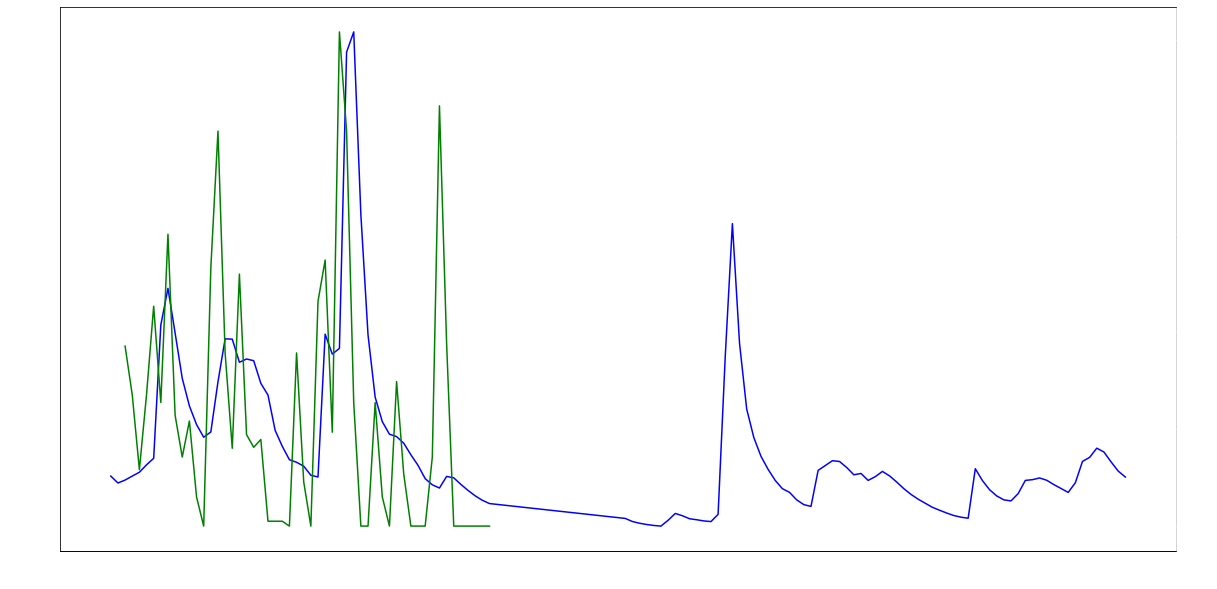

In [3]:

rainflows = df.loc[(df.Name=='Nestucca River Beaver')]

fig, ax = plt.subplots(figsize=(20,10))
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')     


ax.tick_params(axis='x', colors='white')  
ax.tick_params(axis='y', colors='white')  

ax.spines['left'].set_color('white')        
ax.spines['top'].set_color('white')


sns.lineplot(data=rainflows,x='Date',y='CFS',color='b')

ax2 = plt.twinx()

ax2.yaxis.label.set_color('white')

ax2.spines['right'].set_color('white') 
ax2.tick_params(axis='y', colors='white')

sns.lineplot(data=rainflows,x='Date',y='Precip',color='g',ax=ax2)

Lag of Precip/CFS

In [4]:
full = df.loc[df.Precip.isnull()==False]

RiverData = pd.DataFrame()
for n in RiverList:
    s = 0
    CorrList = list()
    while s < 10:
        d = full[['CFS','Precip']].loc[full.Name==n]
        d['Precip'] = d['Precip'].shift(s)
        r = d.dropna()
        corr = r.Precip.corr(r.CFS)
        CorrList.append([s,corr])
        s+=1
    Corrs = pd.DataFrame(CorrList,columns=['PrecipLag','Corr'])
    BestShift = Corrs.sort_values(by='Corr',ascending=False).head(1)
    BestShift['Name'] = n
    RiverData = RiverData.append(BestShift)
RiverData.sort_values('Corr')

c:\Users\Scott\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Scott\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Lag,Corr,Name
3,3,0.086179,Pit River
5,5,0.140367,Trinity River Burnt Ranch
9,9,0.260435,Trinity River Lewiston
1,1,0.302070,Mattole River Ettersburg
9,9,0.355992,Trinity River Junction City
9,9,0.397358,Mad River
1,1,0.421832,Rogue River Agness
8,8,0.448832,East Walker
1,1,0.458071,Umpqua River Elkton
6,6,0.468087,North Fork American River


In [5]:
full = full.reset_index().set_index('Name').join(RiverData.set_index('Name'))
full = full.reset_index()

In [6]:
counts = full.groupby('Name').count()['Date_Name']
RiverData = RiverData.set_index('Name').join(counts).rename(columns={'Date_Name':'Counts'}).reset_index()

In [7]:
final_RiverData = RiverData.loc[RiverData['Counts']>20]

For the rivers in final_RiverData, flag the good fishing days.


Grade water discharge

In [44]:
prev_river = ''
ratelist = []
r=full.CFS[0]


def transformfunc(x,r):
    transformedDate = 1/np.log((x/r)*100)
    return transformedDate
for i in range(0,len(full.CFS)):
    if full.Name[i] == prev_river:
        rate = transformfunc(full.CFS[i],r)
        r= full.CFS[i]
        ratelist.append(rate)
    else:
        r = full.CFS[i]
        rate = transformfunc(full.CFS[i],r)
        r= full.CFS[i]
        ratelist.append(rate)
        prev_river = full.Name[i]

full['DischargeRateChange'] = ratelist

<ipython-input-44-f62c8bc85302>:7: RuntimeWarning: invalid value encountered in log
  transformedDate = 1/np.log((x/r)*100)


<AxesSubplot:xlabel='Date', ylabel='DischargeRateChange'>

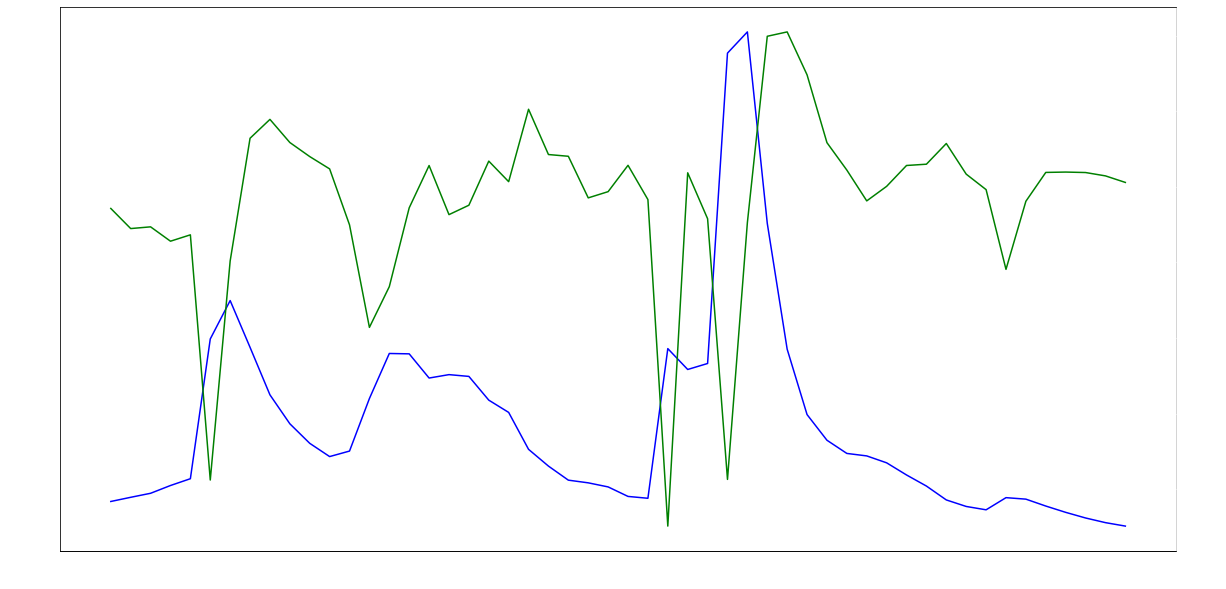

In [45]:
# Water Discharge and Discharge Rate of Change
rainflows = full.loc[(full.Name=='Nestucca River Beaver')]

fig, ax = plt.subplots(figsize=(20,10))
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')     


ax.tick_params(axis='x', colors='white')  
ax.tick_params(axis='y', colors='white')  

ax.spines['left'].set_color('white')        
ax.spines['top'].set_color('white')


sns.lineplot(data=rainflows,x='Date',y='CFS',color='b')

ax2 = plt.twinx()

ax2.yaxis.label.set_color('white')

ax2.spines['right'].set_color('white') 
ax2.tick_params(axis='y', colors='white')

sns.lineplot(data=rainflows,x='Date',y='DischargeRateChange',color='g',ax=ax2)

Using fishingflag as the dependent variable, create an arima model.